In [0]:
#https://www.kaggle.com/c/competitive-data-science-final-project

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Reshape, Dropout
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
import os
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import preprocessing
from scipy import stats

In [4]:
!pip install pydrive

    100% |████████████████████████████████| 993kB 8.6MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
def listGDrive():
  file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
  for file1 in file_list:
    print('title: %s, id: %s' % (file1['title'], file1['id']))
    
def saveToGDrive(filename):
  file_obj = drive.CreateFile()
  file_obj.SetContentFile(filename)
  file_obj.Upload()

In [21]:
listGDrive()

title: Copy of FinalProject.ipynb, id: 1VNoTlQCo0vopZGNer3itgFSVYRwY4hv7
title: FinalProject.ipynb, id: 1TVHYYt18b_tb9Rqm5CVS_vSiRJwcmpbT
title: weights-2500-1000-500-250-01-0.92.hdf5, id: 1C9JgZ4dk_2PS-tLKzyHBTonKGZh95gdB
title: weights-1000-500-01-0.79.hdf5, id: 17cz2NzCLOt-Nq71nNqtwsm-nYzrSSa1G
title: weights-7500-5000-2500-1250-750-500-250-100-01-0.92.hdf5, id: 1LdTCm5WjiXvPR1qebpsKb6xbtQWk5dn-
title: training_data.pickle, id: 1ceHdkVO5F_Ajo0snQYJ5E_d_Ga8h1icV
title: X_test.pickle, id: 1c-48oVl_2XyTMnrdUW-mIUCFA0PCfOg1
title: test.csv.gz, id: 1TuwccBQbiRiv0Y1Uc_ix4LZL_H-NFKp1
title: sales_train.csv.gz, id: 1cCxspLXaU6dTtrtr5SP_5a7RD2TE0ObB
title: items.csv, id: 12Z8TBuT6lasQKpja1TM7jBuVOWG_kp9i
title: shops.csv, id: 19JobZXRF8sixPGr3O68M2Ol6cqG-qj_a
title: item_categories.csv, id: 1hwSz13wJzOSNNOa6dldhJBBBXyHZxORR
title: PyDrive-and-KaggleAPI.ipynb, id: 1JjHfvSdYadvuP4iv5hwjTf8kl7QH_PI3
title: train.csv, id: 1GXKSBKxl8scDgU6wpA3amHEI6lEQARqc
title: test.csv, id: 13F6SHuM3ukq1VDq_RW

In [0]:
file_obj = drive.CreateFile({'id': '1cCxspLXaU6dTtrtr5SP_5a7RD2TE0ObB'})
file_obj.GetContentFile('sales_train.csv.gz') 

In [0]:
file_obj = drive.CreateFile({'id': '1TuwccBQbiRiv0Y1Uc_ix4LZL_H-NFKp1'})
file_obj.GetContentFile('test.csv.gz') 

In [0]:
file_obj = drive.CreateFile({'id': '12Z8TBuT6lasQKpja1TM7jBuVOWG_kp9i'})
file_obj.GetContentFile('items.csv')  

In [0]:
file_obj = drive.CreateFile({'id': '19JobZXRF8sixPGr3O68M2Ol6cqG-qj_a'})
file_obj.GetContentFile('shops.csv') 

In [0]:
file_obj = drive.CreateFile({'id': '1hwSz13wJzOSNNOa6dldhJBBBXyHZxORR'})
file_obj.GetContentFile('item_categories.csv') 

In [0]:
def parse_date(df):
  df["date"] = pd.to_datetime(df.date, format="%d.%m.%Y")
  return df

def get_week_of_month(dt):
  return (dt.day-1)//7+1
  
def get_is_last_week_of_month(dt):
  weekofmonth = get_week_of_month(dt)
  if weekofmonth == 4 or weekofmonth == 5:
    return True
  else:
    return False
  
def get_is_weekend(dt):
  dayofweek = dt.dayofweek
  if dayofweek == 5 or dayofweek == 6 or dayofweek == 7:
    return True
  else:
    return False
  
# https://stackoverflow.com/questions/29688899/pandas-checking-if-a-date-is-a-holiday-and-assigning-boolean-value
#def get_is_holiday(dt):
#  return False
  
def generate_date_features(df):
  df["day"] = df.date.apply(lambda x: x.day)
  df["month"] = df.date.apply(lambda x: x.month)
  df["year"] = df.date.apply(lambda x: x.year)
  df["quarter"] = df.date.apply(lambda x: x.quarter)
  df["dayofweek"] = df.date.apply(lambda x: x.dayofweek)
  df["dayofyear"] = df.date.apply(lambda x: x.dayofyear)
  df["weekofyear"] = df.date.apply(lambda x: x.weekofyear)
  df["weekofmonth"] = df.date.apply(lambda x: get_week_of_month(x))
  df["islastweekofmonth"] = df.date.apply(lambda x: get_is_last_week_of_month(x))
  df["islastdayofmonth"] = df.date.apply(lambda x: x.is_month_end)
  df["isweekend"] = df.date.apply(lambda x: get_is_weekend(x))
  return df

# Transformers
parse_date_transformer = FunctionTransformer(parse_date, validate=False)
generate_date_features_transformer = FunctionTransformer(generate_date_features, validate=False)

# Pipelines
date_pipeline = make_pipeline(parse_date_transformer, generate_date_features_transformer)

# Main Pipeline
preprocessing_pipeline = make_pipeline(date_pipeline)

In [0]:
t0 = time.time()
sales_df = preprocessing_pipeline.transform(pd.read_csv("sales_train.csv.gz"))
t1 = time.time()
print(t1-t0)
sales_df.head()

272.76997995376587


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,quarter,dayofweek,dayofyear,weekofyear,weekofmonth,islastweekofmonth,islastdayofmonth,isweekend
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,1,2,2,1,1,False,False,False
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,1,3,3,1,1,False,False,False
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013,1,5,5,1,1,False,False,True
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,1,6,6,1,1,False,False,True
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,1,1,15,3,3,False,False,False


In [0]:
def print_nuniques_per_feature(df):
    for col in list(df.columns.values):
        print(col,":",df[col].nunique(dropna=True))

print_nuniques_per_feature(sales_df)

date : 1034
date_block_num : 34
shop_id : 60
item_id : 21807
item_price : 19993
item_cnt_day : 198
day : 31
month : 12
year : 3
quarter : 4
dayofweek : 7
dayofyear : 365
weekofyear : 52
weekofmonth : 5
islastweekofmonth : 2
islastdayofmonth : 2
isweekend : 2


In [0]:
items_df = pd.read_csv("items.csv")
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [0]:
print("item_name:",items_df["item_name"].nunique(dropna=True))
print("item_category_id:",items_df["item_category_id"].nunique(dropna=True))

item_name: 22170
item_category_id: 84


In [0]:
items_categories_df = pd.read_csv("item_categories.csv")
items_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [0]:
print("item_category_name:",items_categories_df["item_category_name"].nunique(dropna=True))
print("item_category_id:",items_categories_df["item_category_id"].nunique(dropna=True))

item_category_name: 84
item_category_id: 84


In [0]:
shops_df = pd.read_csv("shops.csv")
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [0]:
print("shop_name:",shops_df["shop_name"].nunique(dropna=True))
print("shop_id:",shops_df["shop_id"].nunique(dropna=True))

shop_name: 60
shop_id: 60


In [0]:
sales_df["shop_item_id"] = sales_df["shop_id"].astype(str).map(str) + sales_df["item_id"].astype(str)
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,quarter,dayofweek,dayofyear,weekofyear,weekofmonth,islastweekofmonth,islastdayofmonth,isweekend,shop_item_id
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,1,2,2,1,1,False,False,False,5922154
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,1,3,3,1,1,False,False,False,252552
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013,1,5,5,1,1,False,False,True,252552
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,1,6,6,1,1,False,False,True,252554
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,1,1,15,3,3,False,False,False,252555


In [0]:
sales_df["shop_item_id"] = LabelEncoder().fit_transform(sales_df["shop_item_id"])
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,quarter,dayofweek,dayofyear,weekofyear,weekofmonth,islastweekofmonth,islastdayofmonth,isweekend,shop_item_id
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,1,2,2,1,1,False,False,False,391689
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,1,3,3,1,1,False,False,False,116138
2,2013-01-05,0,25,2552,899.00,-1.0,5,1,2013,1,5,5,1,1,False,False,True,116138
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,1,6,6,1,1,False,False,True,116140
4,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,1,1,15,3,3,False,False,False,116141


In [0]:
clipped_values = (sales_df.item_cnt_day > -2) & (sales_df.item_cnt_day <= 20) & (sales_df.item_price < 30000.00) #43000.00)
mydf = sales_df[clipped_values]
mydf.shape

(2932091, 18)

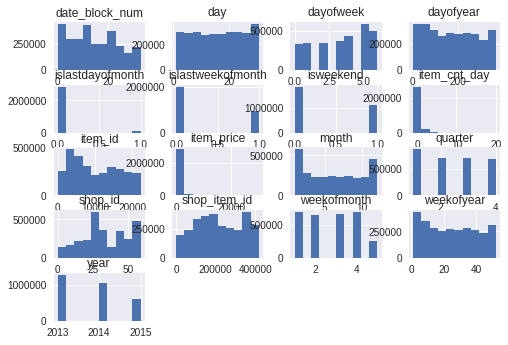

In [0]:
mydf.hist()
plt.show()

In [0]:
mydf.groupby(['item_price'])['item_price'].count().reset_index(name='count').sort_values(['count'], ascending=False)
#mydf.groupby(['item_price'])['item_price'].count().nlargest(5)#.mean()

,item_price,count
3715,299.000000,291319
5150,399.000000,242586
1435,149.000000,218428
2196,199.000000,184032
4380,349.000000,101456
7432,599.000000,95650
10818,999.000000,82631
9272,799.000000,77859
2947,249.000000,77679
8430,699.000000,76442


In [0]:
mymerge_df = mydf.merge(items_df)
mymerge_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,quarter,dayofweek,dayofyear,weekofyear,weekofmonth,islastweekofmonth,islastdayofmonth,isweekend,shop_item_id,item_name,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,2,1,2013,1,2,2,1,1,False,False,False,391689,ЯВЛЕНИЕ 2012 (BD),37
1,2013-01-23,0,24,22154,999.0,1.0,23,1,2013,1,2,23,4,4,True,False,False,102671,ЯВЛЕНИЕ 2012 (BD),37
2,2013-01-20,0,27,22154,999.0,1.0,20,1,2013,1,6,20,3,3,False,False,True,138064,ЯВЛЕНИЕ 2012 (BD),37
3,2013-01-02,0,25,22154,999.0,1.0,2,1,2013,1,2,2,1,1,False,False,False,115920,ЯВЛЕНИЕ 2012 (BD),37
4,2013-01-03,0,25,22154,999.0,1.0,3,1,2013,1,3,3,1,1,False,False,False,115920,ЯВЛЕНИЕ 2012 (BD),37


In [0]:
mymerge_df.drop(["date", "item_name"], axis=1, inplace=True)
mymerge_df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,quarter,dayofweek,dayofyear,weekofyear,weekofmonth,islastweekofmonth,islastdayofmonth,isweekend,shop_item_id,item_category_id
0,0,59,22154,999.0,1.0,2,1,2013,1,2,2,1,1,False,False,False,391689,37
1,0,24,22154,999.0,1.0,23,1,2013,1,2,23,4,4,True,False,False,102671,37
2,0,27,22154,999.0,1.0,20,1,2013,1,6,20,3,3,False,False,True,138064,37
3,0,25,22154,999.0,1.0,2,1,2013,1,2,2,1,1,False,False,False,115920,37
4,0,25,22154,999.0,1.0,3,1,2013,1,3,3,1,1,False,False,False,115920,37


In [0]:
def print_min_max(df):
    for col in list(df.columns.values):
        print("col:",col,"\nmin:",df[col].min(),"\nmax:",df[col].max())

print_min_max(mymerge_df)

col: date_block_num 
min: 0 
max: 33
col: shop_id 
min: 0 
max: 59
col: item_id 
min: 0 
max: 22169
col: item_price 
min: -1.0 
max: 29999.0
col: item_cnt_day 
min: -1.0 
max: 20.0
col: day 
min: 1 
max: 31
col: month 
min: 1 
max: 12
col: year 
min: 2013 
max: 2015
col: quarter 
min: 1 
max: 4
col: dayofweek 
min: 0 
max: 6
col: dayofyear 
min: 1 
max: 365
col: weekofyear 
min: 1 
max: 52
col: weekofmonth 
min: 1 
max: 5
col: islastweekofmonth 
min: False 
max: True
col: islastdayofmonth 
min: False 
max: True
col: isweekend 
min: False 
max: True
col: shop_item_id 
min: 0 
max: 417994
col: item_category_id 
min: 0 
max: 83


In [0]:
mymerge_df.isnull().values.any()

False

In [0]:
y = mymerge_df["item_cnt_day"].values
print(y.shape)
train_df = mymerge_df.drop(["item_cnt_day"], axis=1)
print(train_df.shape)

(2932091,)
(2932091, 17)


In [0]:
def pickle_write(filename, obj):
  fileObject = open(filename,"wb") 
  pickle.dump(obj,fileObject)   
  fileObject.close()
  
def pickle_read(filename):
  return pickle.load(open(filename,"rb"))  

In [0]:
training_data_filename = "training_data.pickle"

In [0]:
pickle_write(training_data_filename, (train_df,y))
saveToGDrive(training_data_filename)
listGDrive()

In [0]:
file_obj = drive.CreateFile({'id': '1ceHdkVO5F_Ajo0snQYJ5E_d_Ga8h1icV'})
file_obj.GetContentFile(training_data_filename) 

In [10]:
(train_df, y) = pickle_read(training_data_filename)
print(y.shape)
train_df.head()

(2932091,)


,date_block_num,shop_id,item_id,item_price,day,month,year,quarter,dayofweek,dayofyear,weekofyear,weekofmonth,islastweekofmonth,islastdayofmonth,isweekend,shop_item_id,item_category_id
0,0,59,22154,999.0,2,1,2013,1,2,2,1,1,False,False,False,391689,37
1,0,24,22154,999.0,23,1,2013,1,2,23,4,4,True,False,False,102671,37
2,0,27,22154,999.0,20,1,2013,1,6,20,3,3,False,False,True,138064,37
3,0,25,22154,999.0,2,1,2013,1,2,2,1,1,False,False,False,115920,37
4,0,25,22154,999.0,3,1,2013,1,3,3,1,1,False,False,False,115920,37


In [11]:
train_df["year"] = LabelEncoder().fit_transform(train_df["year"])
train_df[train_df.year==1].head()

,date_block_num,shop_id,item_id,item_price,day,month,year,quarter,dayofweek,dayofyear,weekofyear,weekofmonth,islastweekofmonth,islastdayofmonth,isweekend,shop_item_id,item_category_id
66,17,28,2552,949.0,28,6,1,2,5,179,26,4,True,False,True,150540,58
114,12,42,2555,1149.0,19,1,1,1,6,19,3,3,False,False,True,246145,56
115,13,31,2555,1149.0,11,2,1,1,1,42,7,2,False,False,False,182447,56
116,13,19,2555,1149.0,10,2,1,1,0,41,7,2,False,False,False,70103,56
117,13,50,2555,1149.0,22,2,1,1,5,53,8,4,True,False,True,306579,56


In [12]:
#train_df.drop(["shop_item_id"], axis=1, inplace=True)
train_df.drop(["islastweekofmonth","islastdayofmonth","isweekend"], axis=1, inplace=True)
train_df.head()

,date_block_num,shop_id,item_id,item_price,day,month,year,quarter,dayofweek,dayofyear,weekofyear,weekofmonth,shop_item_id,item_category_id
0,0,59,22154,999.0,2,1,0,1,2,2,1,1,391689,37
1,0,24,22154,999.0,23,1,0,1,2,23,4,4,102671,37
2,0,27,22154,999.0,20,1,0,1,6,20,3,3,138064,37
3,0,25,22154,999.0,2,1,0,1,2,2,1,1,115920,37
4,0,25,22154,999.0,3,1,0,1,3,3,1,1,115920,37


In [0]:
#def one_hot_encoding(idx):
#    y = np.zeros((len(idx),max(idx)+1))
#    y[np.arange(len(idx)), idx] = 1
#    return y

In [0]:
def get_embedding(df, col):
  input_feat = Input(shape=(1,))
  maxval = df[col].max().astype(int) 
  #embedding_size = max(2, min(50, (maxval+1)//2)) 
  embedding_size = min(50, (maxval+1)//2) 
  if col == "item_price" or col == "shop_item_id":
    output_feat = Dense(1, name=col+"_dense")(input_feat)
  else:
    output_embedding = Embedding((maxval+1), embedding_size, input_length=1, name=col+"_embedding")(input_feat)
    output_feat = Reshape(target_shape=(embedding_size,))(output_embedding)
  return input_feat, output_feat

In [0]:
def get_features_and_embeddings(df, col_set=None):
  X_features = []
  input_model = []
  output_embeddings = []
  col_list = []
  if col_set is None:
    col_list = list(df.columns.values)
  else:
    col_list = list(col_set)
  for col in col_list:
    X_features.append(df[col].values)
    input_feat, output_feat = get_embedding(df, col)
    input_model.append(input_feat)
    output_embeddings.append(output_feat)
  return np.array(X_features), input_model, output_embeddings

In [0]:
def check_dataset_counts(X, y):
  assert X[0].shape[0] == y.shape[0], \
    "training set count does not match target/labels count"
  print(X.shape)

In [16]:
one_hot_as_input = False
#save_embeddings = True

# TODO: implement one_hot inputs for comparison purposes
if one_hot_as_input:
  print("Using one-hot encoding as input")
  #enc = OneHotEncoder(sparse=False)
  #enc.fit(X)
  #X = enc.transform(X)
else:
  print("Using learned embeddings as input")
  X, input_model, output_embeddings = get_features_and_embeddings(train_df) #get_features_and_embeddings(sales_df,{"shop_id","item_id","item_price","item_cnt_day","day","month","year"})

check_dataset_counts(X, y)

Using learned embeddings as input
(14, 2932091)


In [17]:
shuffle_data = True

if shuffle_data:
  print("Using shuffled data")
  sh = np.arange(y.shape[0])
  np.random.shuffle(sh)
  for ii in range(len(X)):
    X[ii] = X[ii][sh]
  y = y[sh]

train_ratio = 0.9  
num_features = X.shape[0]
num_records = X.shape[1]
train_size = int(train_ratio * num_records)
  
X_train = np.zeros((num_features,train_size))
X_val = np.zeros((num_features,num_records-train_size))
for ii in range(num_features):
    X_train[ii] = X[ii][:train_size]
for ii in range(num_features):
    X_val[ii] = X[ii][train_size:]
y_train = y[:train_size]
y_val = y[train_size:]

del X

print(X_train.shape)
print(X_val.shape)

Using shuffled data
(14, 2638881)
(14, 293210)


In [18]:
print(stats.describe(y_train))
print(y_train.shape)
print(stats.describe(y_val))
print(y_val.shape)

DescribeResult(nobs=2638881, minmax=(-1.0, 20.0), mean=1.1955215108222008, variance=0.8859687110892496, skewness=9.35830608785633, kurtosis=122.20955647475508)
(2638881,)
DescribeResult(nobs=293210, minmax=(-1.0, 20.0), mean=1.1988472425906347, variance=0.9117264830479137, skewness=9.250850685752269, kurtosis=118.8305482997252)
(293210,)


In [19]:
output_model = Concatenate()(output_embeddings)
output_model = Dense(1000)(output_model) #1000
output_model = Activation('relu')(output_model)
#output_model = Dropout(.15)(output_model)
output_model = Dense(500)(output_model) #1000
output_model = Activation('relu')(output_model)
#output_model = Dropout(.15)(output_model)
output_model = Dense(1)(output_model)
#output_model = Activation('tanh')(output_model)
output_model = Activation('linear')(output_model)

model = Model(inputs=input_model, outputs=output_model)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (I

In [0]:
del output_model
del model

In [0]:
weights_filename="weights-1000-500-01-0.79.hdf5"

In [0]:
file_obj = drive.CreateFile({"id": "17cz2NzCLOt-Nq71nNqtwsm-nYzrSSa1G"})
file_obj.GetContentFile(weights_filename) 

In [0]:
model.load_weights(weights_filename)

In [0]:
model.compile(loss='mean_squared_error', optimizer='adam')

# checkpoint
weights_filepath="weights-1000-500-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#weights_filepath="weights-1000-500-{epoch:02d}-{loss:.2f}.hdf5"
#checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [0]:
scale_target_labels = False

SCALER_MIN = -1
SCALER_MAX = 1

# sanity check
y_sanity = np.array([3.0,4.0,13.0,-1.0,-1.0])

if scale_target_labels is True:
  down_scaler = MinMaxScaler(feature_range=(SCALER_MIN, SCALER_MAX), copy=True)
  y_train_rs = np.reshape(y_train,(-1,1))
  y_train_scaler = down_scaler.fit(y_train_rs)
  SCALER_MIN = y_train_scaler.data_min_[0]
  SCALER_MAX = y_train_scaler.data_max_[0]
  y_train = down_scaler.transform(y_train_rs)
  y_val = down_scaler.fit_transform(np.reshape(y_val,(-1,1)))
  y_sanity = down_scaler.fit_transform(np.reshape(y_sanity,(-1,1)))
  print(SCALER_MIN,SCALER_MAX)

In [26]:
normalize_input = True

def get_standardized_inputs(X,slice_size=None):
  inputs = []
  for ii in range(len(X)):
    if ii == 3:
      inputs.append(preprocessing.normalize(np.reshape(X[ii][slice_size:],(-1,1)), axis=0))
    elif ii == 13: #16:
      inputs.append(preprocessing.scale(np.reshape(X[ii][slice_size:],(-1,1)), axis=0))
    else:
      inputs.append(X[ii][slice_size:])
  return inputs

if normalize_input is True:
  X_train_inputs = get_standardized_inputs(X_train) #,slice_size=293210*2)
  X_val_inputs = get_standardized_inputs(X_val)
  # sanity check
  sanity_inputs = [np.array([0,0,0,0,0]), np.array([25,25,25,25,24]),np.array([2573,2808,2972,2330,1628]),preprocessing.normalize(np.reshape(np.array([299.0,999.0,599.0,599.0,3899.00]),(-1,1)), axis=0),np.array([3,11,25,2,14]),np.array([1,1,1,1,1]),np.array([2013,2013,2013,2013,2013]),np.array([1,1,1,1,1]),np.array([3,4,4,2,0]),np.array([3,11,25,2,14]),np.array([1,2,4,1,3]),np.array([1,2,4,1,2]),np.array([False,False,True,False,False]),np.array([False,False,False,False,False]),np.array([False,False,False,False,False]),preprocessing.scale(np.reshape(np.array([116156,116338,116467,116004,100383]),(-1,1)), axis=0),np.array([55,30,30,30,59])] 
else:
  X_train_inputs = [X_train[ii] for ii in range(len(X_train))]
  X_val_inputs = [X_val[ii] for ii in range(len(X_val))]
  # sanity check
  sanity_inputs = [np.array([0,0,0,0,0]), np.array([25,25,25,25,24]),np.array([2573,2808,2972,2330,1628]),np.array([299.0,999.0,599.0,599.0,3899.00]),np.array([3,11,25,2,14]),np.array([1,1,1,1,1]),np.array([2013,2013,2013,2013,2013]),np.array([1,1,1,1,1]),np.array([3,4,4,2,0]),np.array([3,11,25,2,14]),np.array([1,2,4,1,3]),np.array([1,2,4,1,2]),np.array([False,False,True,False,False]),np.array([False,False,False,False,False]),np.array([False,False,False,False,False]),preprocessing.normalize(np.reshape(np.array([116156,116338,116467,116004,100383]),(-1,1)), axis=0),np.array([55,30,30,30,59])] 
  
print(len(X_train_inputs), len(X_val_inputs), len(sanity_inputs))

14 14 17


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [27]:
print(len(X_train_inputs[0]), len(X_val_inputs[0]))

2638881 293210


In [0]:
#scaled = preprocessing.scale(np.reshape(X_val[16],(-1,1)), axis=0)
#print(stats.describe(scaled))
#normalized = preprocessing.normalize(np.reshape(X_val[16],(-1,1)), axis=0)
#print(stats.describe(normalized))

In [0]:
#sanity1 = (mymerge_df.shop_id==25) & (mymerge_df.item_id==2573) & (mymerge_df.item_price==299.0) & (mymerge_df.day==3) & (mymerge_df.month==1) & (mymerge_df.year==2013) & (mymerge_df.item_category_id==55)
#sanity2 = (mymerge_df.shop_id==25) & (mymerge_df.item_id==2808) & (mymerge_df.item_price==999.0) & (mymerge_df.day==11) & (mymerge_df.month==1) & (mymerge_df.year==2013) & (mymerge_df.item_category_id==30)
#sanity3 = (mymerge_df.shop_id==25) & (mymerge_df.item_id==2972) & (mymerge_df.item_price==599.0) & (mymerge_df.day==25) & (mymerge_df.month==1) & (mymerge_df.year==2013) & (mymerge_df.item_category_id==30)
#sanity4 = (mymerge_df.shop_id==25) & (mymerge_df.item_id==2330) & (mymerge_df.item_price==599.0) & (mymerge_df.day==2) & (mymerge_df.month==1) & (mymerge_df.year==2013) & (mymerge_df.item_category_id==30)
#sanity5 = (mymerge_df.shop_id==24) & (mymerge_df.item_id==1628) & (mymerge_df.item_price==3899.00) & (mymerge_df.day==14) & (mymerge_df.month==1) & (mymerge_df.year==2013) & (mymerge_df.item_category_id==59)
#mymerge_df[(sanity1) | (sanity2) | (sanity3) | (sanity4) | (sanity5)].head()

In [35]:
# TODO: fit 5 diff networks and avg the results for prediction
# TODO: plot "history"
#model.fit(sanity_inputs, y_sanity, 
#model.fit(X_train_inputs, y_train, 
#          validation_data=(X_val_inputs, y_val), 
model.fit(X_val_inputs, y_val, 
          validation_data=(X_train_inputs, y_train), 
          epochs=1, batch_size=32, 
          callbacks=callbacks_list,
)

Train on 293210 samples, validate on 2638881 samples
Epoch 1/1
 48064/293210 [===>..........................] - ETA: 3:45 - loss: 1.0093

137024/293210 [=============>................] - ETA: 2:25 - loss: 0.9431

225696/293210 [======================>.......] - ETA: 1:03 - loss: 0.9237

293210/293210 [==============================] - 782s 3ms/step - loss: 0.9118 - val_loss: 0.8864

Epoch 00001: val_loss improved from 0.91174 to 0.88638, saving model to weights-1000-500-01-0.89.hdf5


In [36]:
saveToGDrive("weights-1000-500-01-0.89.hdf5")
listGDrive()

title: weights-1000-500-01-0.89.hdf5, id: 1dSJUF0o_dcbrIXCuKg_CxCjYSQt0wxjC
title: Copy of FinalProject.ipynb, id: 1VNoTlQCo0vopZGNer3itgFSVYRwY4hv7
title: FinalProject.ipynb, id: 1TVHYYt18b_tb9Rqm5CVS_vSiRJwcmpbT
title: weights-1000-500-01-0.91.hdf5, id: 11aZCQrsZl4koEt4f7oxR_gbQ9Fdm3TuJ
title: training_data.pickle, id: 1ceHdkVO5F_Ajo0snQYJ5E_d_Ga8h1icV
title: X_test.pickle, id: 1c-48oVl_2XyTMnrdUW-mIUCFA0PCfOg1
title: test.csv.gz, id: 1TuwccBQbiRiv0Y1Uc_ix4LZL_H-NFKp1
title: sales_train.csv.gz, id: 1cCxspLXaU6dTtrtr5SP_5a7RD2TE0ObB
title: items.csv, id: 12Z8TBuT6lasQKpja1TM7jBuVOWG_kp9i
title: shops.csv, id: 19JobZXRF8sixPGr3O68M2Ol6cqG-qj_a
title: item_categories.csv, id: 1hwSz13wJzOSNNOa6dldhJBBBXyHZxORR
title: PyDrive-and-KaggleAPI.ipynb, id: 1JjHfvSdYadvuP4iv5hwjTf8kl7QH_PI3
title: train.csv, id: 1GXKSBKxl8scDgU6wpA3amHEI6lEQARqc
title: test.csv, id: 13F6SHuM3ukq1VDq_RWE16X3RkSM5DqZ2
title: kaggle.json, id: 1XQYzuXa5bbTpEo55wrTI3aUKunL8GRvS
title: cookies.txt, id: 1Dfw0bts0smorsE

In [0]:
test_df = pd.read_csv("test.csv.gz")
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [0]:
test_df.shape

(214200, 3)

In [0]:
#item_price_previous_month = (sales_df.month == 10) & (sales_df.year == 2015)
#item_price_previous_month_df = sales_df[item_price_previous_month].groupby(["shop_id", "item_id"], as_index=False).item_price.mean() #.rename(columns={"item_cnt_day": "item_cnt_month"})
#item_price_previous_month_df.head()

In [0]:
most_recent_entries_df = pd.DataFrame(sales_df[["date","shop_id","item_id","item_price"]].groupby(["shop_id","item_id"], as_index=False)["date"].max())
most_recent_entries_df.head()

,shop_id,item_id,date
0,0,30,2013-02-26
1,0,31,2013-02-26
2,0,32,2013-02-25
3,0,33,2013-02-26
4,0,35,2013-02-24


In [0]:
most_recent_prices_df = pd.merge(most_recent_entries_df, sales_df, how="left", on=["shop_id", "item_id", "date"])
most_recent_prices_df.head()

,shop_id,item_id,date,date_block_num,item_price,item_cnt_day,day,month,year
0,0,30,2013-02-26,1,265.0,3.0,26,2,2013
1,0,31,2013-02-26,1,434.0,1.0,26,2,2013
2,0,32,2013-02-25,1,221.0,1.0,25,2,2013
3,0,33,2013-02-26,1,347.0,1.0,26,2,2013
4,0,35,2013-02-24,1,247.0,1.0,24,2,2013


In [0]:
most_recent_prices_df.drop(["date", "date_block_num", "item_cnt_day", "day", "month", "year"], axis=1, inplace=True)
most_recent_prices_df.head()

,shop_id,item_id,item_price
0,0,30,265.0
1,0,31,434.0
2,0,32,221.0
3,0,33,347.0
4,0,35,247.0


In [0]:
test_df = pd.merge(test_df, most_recent_prices_df, how="left", on=["shop_id", "item_id"])
test_df.head()

,ID,shop_id,item_id,item_price
0,0,5,5037,749.5
1,1,5,5320,NaN
2,2,5,5233,1199.0
3,3,5,5232,599.0
4,4,5,5268,NaN


In [0]:
test_df["day"] = np.random.randint(1, 31, test_df.shape[0])
test_df["month"] = pd.Series(11, index=test_df.index)
test_df["year"] = pd.Series(2015, index=test_df.index)
test_df.tail()

,ID,shop_id,item_id,item_price,day,month,year
214196,214195,45,18454,99.0,17,11,2015
214197,214196,45,16188,NaN,1,11,2015
214198,214197,45,15757,199.0,4,11,2015
214199,214198,45,19648,NaN,23,11,2015
214200,214199,45,969,549.0,6,11,2015


In [0]:
test_df = test_df.merge(items_df)
test_df.head()

,ID,shop_id,item_id,item_price,day,month,year,item_name,item_category_id
0,0,5,5037,749.500000,3,11,2015,"NHL 15 [PS3, русские субтитры]",19
1,5100,4,5037,749.333333,23,11,2015,"NHL 15 [PS3, русские субтитры]",19
2,10200,6,5037,1499.000000,6,11,2015,"NHL 15 [PS3, русские субтитры]",19
3,15300,3,5037,1499.000000,12,11,2015,"NHL 15 [PS3, русские субтитры]",19
4,20400,2,5037,749.500000,28,11,2015,"NHL 15 [PS3, русские субтитры]",19


In [0]:
test_df.drop(["item_name"], axis=1, inplace=True)
test_df.head()

,ID,shop_id,item_id,item_price,day,month,year,item_category_id
0,0,5,5037,749.500000,3,11,2015,19
1,5100,4,5037,749.333333,23,11,2015,19
2,10200,6,5037,1499.000000,6,11,2015,19
3,15300,3,5037,1499.000000,12,11,2015,19
4,20400,2,5037,749.500000,28,11,2015,19


In [0]:
test_df.shape

(214201, 8)

In [0]:
test_df["item_price"].isnull().values.any()

True

In [0]:
test_df[test_df["item_price"].isnull()].head()

,ID,shop_id,item_id,item_price,day,month,year,item_category_id
30,153000,55,5037,NaN,24,11,2015,19
32,163200,36,5037,NaN,17,11,2015,19
42,1,5,5320,NaN,19,11,2015,55
43,5101,4,5320,NaN,6,11,2015,55
44,10201,6,5320,NaN,21,11,2015,55


In [0]:
def fx(xx):
  item_price = xx["item_price"]
  if np.isnan(item_price):
    tmp_df = sales_df[sales_df.item_id==xx["item_id"]]
    if (tmp_df.empty):
      item_price = 599.00 # roughly the mean of top 13 occurring item prices 279.00 # mean of top 5 occurring item prices
    else:
      item_price_df = tmp_df.groupby(["item_id"],as_index=False)["item_price"].mean()
      del tmp_df
      item_price = np.array(item_price_df)[0][1]
  return item_price
 
test_df["item_price"] = test_df.apply(lambda xx : fx(xx), axis=1)

In [0]:
test_df.isnull().values.any()

False

In [0]:
test_df[test_df["item_price"].isnull()].head()

,ID,shop_id,item_id,day,month,year,item_price,item_category_id


In [0]:
test_df.shape

(214201, 8)

In [0]:
#test_df["item_price"].size

In [0]:
#test_df["item_price"].count()

In [0]:
#test_df["item_price"].isnull().sum()

In [0]:
def get_test_features(df):
    X_features = []
    for col in list(df.columns.values):
        X_features.append(df[col].values)
    return np.array(X_features)

X_test = get_test_features(test_df)

In [0]:
X_test.shape

(8, 214201)

In [0]:
X_test_filename = "X_test.pickle"

In [0]:
file_obj = drive.CreateFile({"id": "1c-48oVl_2XyTMnrdUW-mIUCFA0PCfOg1"})
file_obj.GetContentFile(X_test_filename) 

In [0]:
X_test = pickle_read(X_test_filename)
X_test.shape

(8, 214201)

In [0]:
pickle_write(X_test_filename,X_test)

In [0]:
saveToGDrive(X_test_filename)
listGDrive()

title: X_test.pickle, id: 1c-48oVl_2XyTMnrdUW-mIUCFA0PCfOg1
title: FinalProject.ipynb, id: 1TVHYYt18b_tb9Rqm5CVS_vSiRJwcmpbT
title: weights-7520-01-0.00.hdf5, id: 1YXl3uecytYwnL721yUXw7A_XG8JqDfEn
title: test.csv.gz, id: 1TuwccBQbiRiv0Y1Uc_ix4LZL_H-NFKp1
title: sales_train.csv.gz, id: 1cCxspLXaU6dTtrtr5SP_5a7RD2TE0ObB
title: items.csv, id: 12Z8TBuT6lasQKpja1TM7jBuVOWG_kp9i
title: shops.csv, id: 19JobZXRF8sixPGr3O68M2Ol6cqG-qj_a
title: item_categories.csv, id: 1hwSz13wJzOSNNOa6dldhJBBBXyHZxORR
title: PyDrive-and-KaggleAPI.ipynb, id: 1JjHfvSdYadvuP4iv5hwjTf8kl7QH_PI3
title: train.csv, id: 1GXKSBKxl8scDgU6wpA3amHEI6lEQARqc
title: test.csv, id: 13F6SHuM3ukq1VDq_RWE16X3RkSM5DqZ2
title: kaggle.json, id: 1XQYzuXa5bbTpEo55wrTI3aUKunL8GRvS
title: cookies.txt, id: 1Dfw0bts0smorsEcI4xgQbZAQZWu5NrOR
title: Zachary Mccoy's Job Search Plan (Udacity), id: 1HTaMGj8mcGx51RSniXgJIv5BpbxzKHgIK3Cnm4qnJJE
title: 2018-04-18.pdf, id: 1tJa6hT2NhZbwT7R_hP2qAj_JcBn4VjDE
title: Zachary Mccoy: Application Tracker

In [0]:
train_df.head()

,shop_id,item_id,item_price,day,month,year,item_category_id
0,59,22154,999.0,2,1,2013,37
1,24,22154,999.0,23,1,2013,37
2,27,22154,999.0,20,1,2013,37
3,25,22154,999.0,2,1,2013,37
4,25,22154,999.0,3,1,2013,37


In [0]:
test_df.head()

,ID,shop_id,item_id,item_price,day,month,year,item_category_id
0,0,5,5037,749.500000,21,11,2015,19
1,5100,4,5037,749.333333,10,11,2015,19
2,10200,6,5037,1499.000000,4,11,2015,19
3,15300,3,5037,1499.000000,18,11,2015,19
4,20400,2,5037,749.500000,26,11,2015,19


In [0]:
#X_test_inputs = [X_test[1],X_test[2],X_test[3],X_test[4],X_test[5],X_test[6],X_test[7]]
#X_test_inputs = [X_train[0][:5],X_train[1][:5],X_train[2][:5],X_train[3][:5],X_train[4][:5],X_train[5][:5],X_train[6][:5]]
#X_test_inputs = [X_test[1],X_test[2],X_train[2][:X_test[6].shape[0]],X_test[3],X_test[4],X_test[5],X_test[7]]

# sanity check: should be ~[3.0,4.0,13.0,-1.0,-1.0]
X_test_inputs = sanity_inputs
preds = model.predict(X_test_inputs, batch_size=32)
print(preds.shape)
print(preds)

(5, 1)
[[ 3.015646 ]
 [ 3.9981458]
 [13.000479 ]
 [-0.9992895]
 [-0.9985672]]


In [0]:
up_scaler = MinMaxScaler(feature_range=(SCALER_MIN, SCALER_MAX), copy=True)
preds_rs = np.reshape(preds,(-1,1))
preds_s = up_scaler.fit_transform(preds_rs)
print(preds_s.shape)
print(preds_s)

(5, 1)
[[ 5.0133014 ]
 [ 6.5157413 ]
 [20.        ]
 [-0.99334717]
 [-1.        ]]


(5, 1)
[[ 2.493988 ]
 [20.       ]
 [17.037231 ]
 [ 3.2550354]
 [-1.       ]]

In [0]:
train_df.tail()

,shop_id,item_id,item_price,day,month,year,item_category_id
2932086,25,8428,249.0,17,10,2015,40
2932087,25,7903,12198.0,1,10,2015,15
2932088,25,7610,2890.0,29,10,2015,64
2932089,25,7635,2100.0,22,10,2015,64
2932090,25,7640,4040.0,1,10,2015,64


In [0]:
items_df[items_df.item_id==1628].head()

,item_name,item_id,item_category_id
1628,BEATLES Help! 2DVD Deluxe Edition (фирм.),1628,59


In [0]:
sales_df[sales_df.item_cnt_day==13.0].head(n=15)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
352,2013-01-15,0,25,2973,2499.000000,13.0,15,1,2013
404,2013-01-25,0,25,2972,599.000000,13.0,25,1,2013
22226,2013-01-07,0,28,16450,399.000000,13.0,7,1,2013
27419,2013-01-04,0,27,16450,399.000000,13.0,4,1,2013
41681,2013-01-17,0,1,13351,41.000000,13.0,17,1,2013
74008,2013-01-04,0,31,16450,399.000000,13.0,4,1,2013
112199,2013-01-15,0,42,2973,2499.000000,13.0,15,1,2013
119707,2013-02-14,1,51,13344,13.000000,13.0,14,2,2013
122735,2013-02-07,1,42,2753,1199.000000,13.0,7,2,2013
141032,2013-02-22,1,54,2445,1198.961538,13.0,22,2,2013


In [0]:
preds_s = preds

scale_target_labels = False
if scale_target_labels is True:
  up_scaler = MinMaxScaler(feature_range=(SCALER_MIN, SCALER_MAX), copy=True)
  preds_rs = np.reshape(preds,(-1,1))
  preds_s = scaler.fit_transform(preds_rs) 

print(preds_s)

[[1.1789265]
 [1.1789265]
 [1.1789265]
 ...
 [1.1789265]
 [1.1789265]
 [1.1789265]]


In [0]:
preds_s = preds*1073.5#22
print(preds_s)

[[-1050.7637]
 [-1050.7637]
 [-1050.7637]
 ...
 [-1050.7637]
 [-1050.7637]
 [-1050.7637]]


In [0]:
preds_s_pos = preds_s[preds_s>0]
preds_s_neg = preds_s[preds_s<0]
preds_ss = np.concatenate([np.ceil(preds_s_pos),np.floor(preds_s_neg)])
print(preds_ss.shape)
print(preds_ss)

(214201,)
[2. 2. 2. ... 2. 2. 2.]


In [0]:
print(len(preds_ss[preds_ss>10]))

4


In [0]:
print(len(preds_ss[preds_ss<1]))

0


In [0]:
submission_filename = "weights-1000.35-500.15-01-1.03"

In [0]:
submission_df = test_df.drop(["shop_id", "item_id", "item_price", "day", "month", "year", "item_category_id"], axis=1)
submission_df["item_cnt_month"] = preds_ss #.astype(int)
submission_df.drop_duplicates(subset=None, keep='first', inplace=True)
#submission_df.shape
submission_df.sort_values(by=['ID']).head() #.to_csv(submission_filename, sep=",", index=False)

,ID,item_cnt_month
0,0,2.0
42,1,2.0
84,2,2.0
126,3,2.0
168,4,2.0


In [0]:
saveToGDrive(submission_filename)
listGDrive()

title: weights-7520-01-0.00.csv, id: 1xCSgYZk63QjwBlssg7u_qPhxfGmhPTG-
title: FinalProject.ipynb, id: 1TVHYYt18b_tb9Rqm5CVS_vSiRJwcmpbT
title: X_test.pickle, id: 1c-48oVl_2XyTMnrdUW-mIUCFA0PCfOg1
title: weights-7520-01-0.00.hdf5, id: 1YXl3uecytYwnL721yUXw7A_XG8JqDfEn
title: test.csv.gz, id: 1TuwccBQbiRiv0Y1Uc_ix4LZL_H-NFKp1
title: sales_train.csv.gz, id: 1cCxspLXaU6dTtrtr5SP_5a7RD2TE0ObB
title: items.csv, id: 12Z8TBuT6lasQKpja1TM7jBuVOWG_kp9i
title: shops.csv, id: 19JobZXRF8sixPGr3O68M2Ol6cqG-qj_a
title: item_categories.csv, id: 1hwSz13wJzOSNNOa6dldhJBBBXyHZxORR
title: PyDrive-and-KaggleAPI.ipynb, id: 1JjHfvSdYadvuP4iv5hwjTf8kl7QH_PI3
title: train.csv, id: 1GXKSBKxl8scDgU6wpA3amHEI6lEQARqc
title: test.csv, id: 13F6SHuM3ukq1VDq_RWE16X3RkSM5DqZ2
title: kaggle.json, id: 1XQYzuXa5bbTpEo55wrTI3aUKunL8GRvS
title: cookies.txt, id: 1Dfw0bts0smorsEcI4xgQbZAQZWu5NrOR
title: Zachary Mccoy's Job Search Plan (Udacity), id: 1HTaMGj8mcGx51RSniXgJIv5BpbxzKHgIK3Cnm4qnJJE
title: 2018-04-18.pdf, id: 1tJa

#### Previous Value Benchmark ####

A good exercise is to reproduce previous_value_benchmark. As the name suggest - in this benchmark for the each shop/item pair our predictions are just monthly sales from the previous month, i.e. October 2015.

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. If you do it correctly, you'll get precisely 1.16777 on the public leaderboard.

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference.

In [0]:
def submission_df(shop_id_item_id_item_cnt_month_df):
    test_df = pd.read_csv("test.csv.gz")
    sub_df = test_df.merge(shop_id_item_id_item_cnt_month_df, on=["shop_id", "item_id"], how="left")[["ID", "item_cnt_month"]]
    sub_df["item_cnt_month"] = sub_df.item_cnt_month.fillna(0).clip(0, 20)
    return sub_df

def create_submission_file(shop_id_item_id_item_cnt_day_df, submission_name="submission", add_timestamp=True):
    if add_timestamp:
        submission_name = "%s_%d" % (submission_name, time.time())

    path = os.path.abspath(os.path.join("submissions/%s.csv" % submission_name))
    base_dir = os.path.dirname(path)
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
        
    sub_df = submission_df(shop_id_item_id_item_cnt_day_df)
    sub_df.to_csv(path, sep=",", index=False)

In [0]:
ind_previous_month = (sales_df.month == 10) & (sales_df.year == 2015)
sales_previous_month_df = sales_df[ind_previous_month].groupby(["shop_id", "item_id"], as_index=False).item_cnt_day.sum().rename(columns={"item_cnt_day": "item_cnt_month"})

In [0]:
sales_previous_month_df.head()

In [0]:
submission_name = "previous_value_benchmark.csv"
create_submission_file(sales_previous_month_df, submission_name, add_timestamp=False)